In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import griddata
from filterpy.kalman import KalmanFilter
from filterpy.common import Saver
from filterpy.common import Q_discrete_white_noise
%matplotlib inline
%matplotlib widget

In [2]:
# ******************** Data from Admittance Control ***************** ##
#df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_Admittance/admittance.csv") 

# ******************** Data from Admittance Control ***************** ##
#df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_Admittance/admittance.csv") 

## ******************** Data from Candle Position ***************** ##
# df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_candle/candle.csv") 

# # ******************** Data from HP ***************** ##
# df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_HP/HP.csv") 

# ******************** Data from Velocity control ***************** ##
df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_VelControl/velctrl.csv") 

# ******************** Data from angular position control ***************** ##
# df = pd.read_csv("/home/unknown/Documents/PostDoc/bagfiles/rosbag2_link2/link2.csv") 

time = df['__time']
time =  (time.values - time.values[0])

### Data from testing only joint 2 (90 degrees, 180 etc)#######################################
q1 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q1/position'].fillna(method='ffill')
q2 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q2/position'].fillna(method='ffill')
q3 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q3/position'].fillna(method='ffill')
q4 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q4/position'].fillna(method='ffill')
q5 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q5/position'].fillna(method='ffill')
q6 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q6/position'].fillna(method='ffill')

qdot1 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q1/velocity'].fillna(method='ffill')
qdot2 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q2/velocity'].fillna(method='ffill')
qdot3 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q3/velocity'].fillna(method='ffill')
qdot4 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q4/velocity'].fillna(method='ffill')
qdot5 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q5/velocity'].fillna(method='ffill')
qdot6 = df['/jaco/manipulator_skillset/manipulator_skillset/joint/q6/velocity'].fillna(method='ffill')

qdot1_ref = df['/jaco/manipulator_skillset/manipulator_skillset/refsPin_/PinX/velocity'].fillna(method='ffill')
qdot2_ref = df['/jaco/manipulator_skillset/manipulator_skillset/refsPin_/PinY/velocity'].fillna(method='ffill')
qdot3_ref = df['/jaco/manipulator_skillset/manipulator_skillset/refsPin_/PinZ/velocity'].fillna(method='ffill')
qdot4_ref = df['/jaco/manipulator_skillset/manipulator_skillset/refsPin_/PinTx/velocity'].fillna(method='ffill')
qdot5_ref = df['/jaco/manipulator_skillset/manipulator_skillset/refsPin_/PinTy/velocity'].fillna(method='ffill')
qdot6_ref = df['/jaco/manipulator_skillset/manipulator_skillset/refsPin_/PinTz/velocity'].fillna(method='ffill')

q1_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud1/position'].fillna(method='ffill')
q2_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud2/position'].fillna(method='ffill')
q3_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud3/position'].fillna(method='ffill')
q4_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud4/position'].fillna(method='ffill')
q5_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud5/position'].fillna(method='ffill')
q6_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud6/position'].fillna(method='ffill')

qdot1_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud1/velocity'].fillna(method='ffill')
qdot2_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud2/velocity'].fillna(method='ffill')
qdot3_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud3/velocity'].fillna(method='ffill')
qdot4_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud4/velocity'].fillna(method='ffill')
qdot5_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud5/velocity'].fillna(method='ffill')
qdot6_kal = df['/jaco/manipulator_skillset/manipulator_skillset/refs_/taud6/velocity'].fillna(method='ffill')
## *******************************************************************************************###

In [80]:
qdot1_ref

0        NaN
1        NaN
2        NaN
3        NaN
4        0.0
        ... 
14715    0.0
14716    0.0
14717    0.0
14718    0.0
14719    0.0
Name: /jaco/manipulator_skillset/manipulator_skillset/refsPin_/PinX/velocity, Length: 14720, dtype: float64

In [18]:
# def kalman_filter(x0,R1,R2,Q1,Q2):
#     kf = KalmanFilter(dim_x=2, dim_z=2)    
#     dt=0.01
#     kf.x = x0
#     kf.P *= np.array([[1000, 0], [0, 1000]])
#     kf.R= np.array([[R1, 0.],[0.,  R2]])
#     kf.Q = np.array([[Q1, 0.],[0., Q2]])
#     kf.F = np.array([[1., dt],[0., 1]])
#     kf.H =  np.array([[1., 0.],[0.,  1.]])
#     return kf

In [19]:
# def kalman_evolution(kf, q,qdot):
#     xs = []
#     z = np.array([q1.values, qdot1.values])
#     #z.astype(np.float64,casting="unsafe")
#     for i in range(len(time)):
# #         xs = z[:,i]
#         kf.predict()
#         kf.update(z[:,i])
#         xs.append(kf.x)
#     xs = np.array(xs)

In [3]:
def plot_states(q,qdot,q_kal, qdot_kal, ys, label, label2):
    fig, ax = plt.subplots()
    ax = plt.subplot(211)
    plt.plot(qdot.values,'r')
    plt.plot(qdot_kal.values, '--b')
    plt.plot(ys[:,1], ':k')
#     ax.set_ylim(-0.1, 0.1)
    ax.set_ylabel(r"$[deg/s]$", fontsize = 10)
    ax.legend((label[0], label[1]),loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.grid(True)

    ax = plt.subplot(212)
    plt.plot(q.values,'r')
    plt.plot(q_kal.values, '--b')
    plt.plot(ys[:,0], ':k')
#     ax.set_ylim(175, 185)
    ax.set_ylabel(r"$[deg]$", fontsize = 10)
    ax.legend((label2[0], label2[1]),loc='center left', bbox_to_anchor=(1, 0.5))
    fig.tight_layout()
    plt.grid(True)

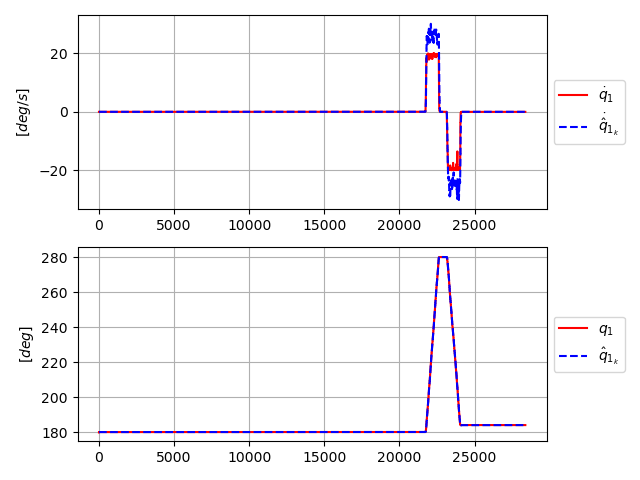

In [5]:
for i in range(len(time)):
    if np.isnan(q1[i]):
        q1[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot1[i]):
        qdot1[i] = 0
        
# for i in range(len(time)):
#     if np.isnan(qdot3_ref[i]):
#         qdot3_ref[i] = 0
        
        
x0 = np.array([180, 0.]).T
R1, R2 = 0.1, 1
Q1, Q2 = 10, 0.01
#kf = kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=2)    
dt=0.01
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R= np.array([[R1, 0.],[0.,  R2]])
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.],[0.,  1.]])
xs = []
z = np.array([q3.values, qdot3.values])
for i in range(len(time)):
#         xs = z[:,i]
    kf.predict()
    kf.update(z[:,i])
    xs.append(kf.x)
xs = np.array(xs)
label1 = [r"$\dot{q}_1$",r"$\dot{\hat{q}}_{1_k}$"]
label2 = [r"$q_1$",r"$\hat{q}_{1_k}$"]
plot_states(q1,qdot1,q1_kal, qdot1_kal, xs, label1, label2)

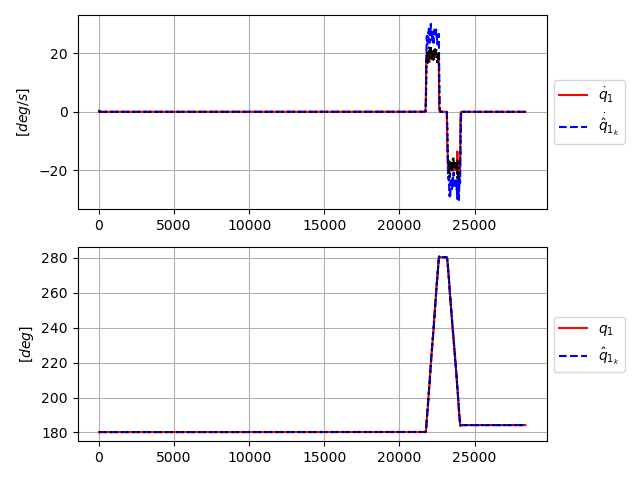

In [19]:
for i in range(len(time)):
    if np.isnan(q1[i]):
        q1[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot3[i]):
        qdot1[i] = 0

# for i in range(len(time)):
#     if np.isnan(qdot3_ref[i]):
#         qdot1_ref[i] = 0
        
x0 = np.array([180, 0.]).T

# R1 = 1
# Q1, Q2 = 0.01, 1
R1 = 0.5
Q1, Q2 = 0.001, 0.1
#kf = kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=1)    
dt=0.01
kf.x = x0
kf.P *= np.array([[Q1, 0], [0, Q2]])
kf.R*= R1 
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.]])
xs = []

for i in range(len(time)):
    kf.predict()
    kf.update(q1[i])
    xs.append(kf.x)
xs = np.array(xs)
xs[:,1] = xs[:,1]*1.7
label1 = [r"$\dot{q}_1$",r"$\dot{\hat{q}}_{1_k}$"]
label2 = [r"$q_1$",r"$\hat{q}_{1_k}$"]
plot_states(q1,qdot1,q1_kal, qdot1_kal, xs, label1, label2)

In [102]:
q3.shape

(14720,)

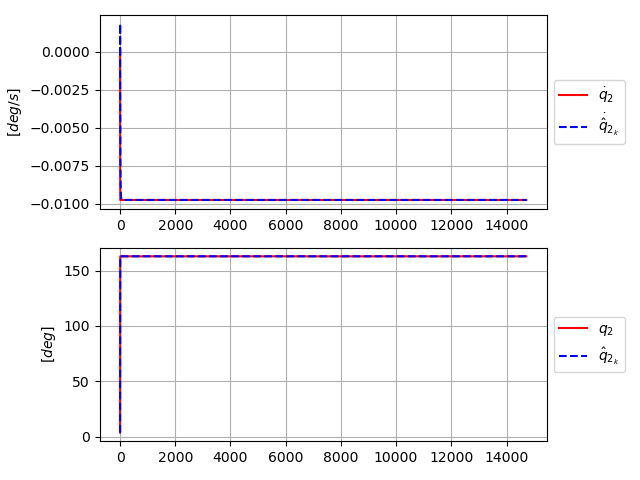

In [51]:
for i in range(len(time)):
    if np.isnan(q2[i]):
        q2[i] = 4.
    
for i in range(len(time)):
    if np.isnan(qdot2[i]):
        qdot2[i] = 0
x0 = np.array([180, 0.]).T
R1, R2 = 0.1, 1
Q1, Q2 = 10, 0.01
z = np.array([q2.values, qdot2.values])
#kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=2)    
dt=0.001
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R= np.array([[R1, 0.],[0.,  R2]])
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.],[0.,  1.]])
xs2 = []
for i in range(len(q2.values)):
    kf.predict()
    kf.update(z[:,i])
    xs2.append(kf.x)
xs2 = np.array(xs2)
label1 = [r"$\dot{q}_2$",r"$\dot{\hat{q}}_{2_k}$"]
label2 = [r"$q_2$",r"$\hat{q}_{2_k}$"]
plot_states(q2,qdot2, xs2, label1, label2)

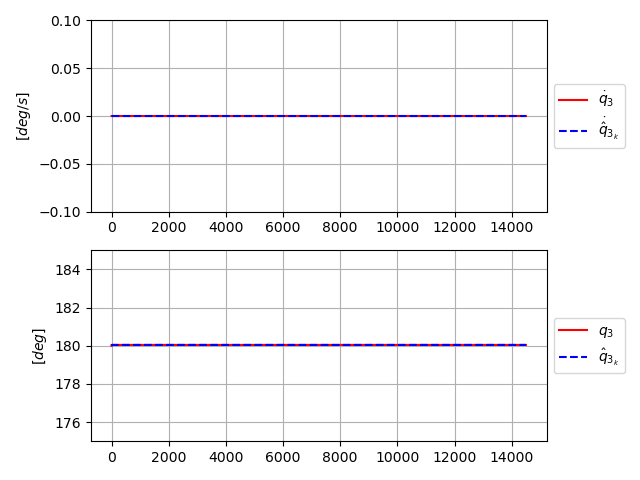

In [23]:
for i in range(len(time)):
    if np.isnan(q3[i]):
        q3[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot3[i]):
        qdot3[i] = 0
x0 = np.array([180, 0.]).T
R1, R2 = 0.1, 1
Q1, Q2 = 10, 0.01
z = np.array([q3.values, qdot3.values])
#kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=2)    
dt=0.001
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R= np.array([[R1, 0.],[0.,  R2]])
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.],[0.,  1.]])
xs3 = []
for i in range(len(q3.values)):
    kf.predict()
    kf.update(z[:,i])
    xs3.append(kf.x)
xs3 = np.array(xs3)
label1 = [r"$\dot{q}_3$",r"$\dot{\hat{q}}_{3_k}$"]
label2 = [r"$q_3$",r"$\hat{q}_{3_k}$"]
plot_states(q3,qdot3, xs3, label1, label2)

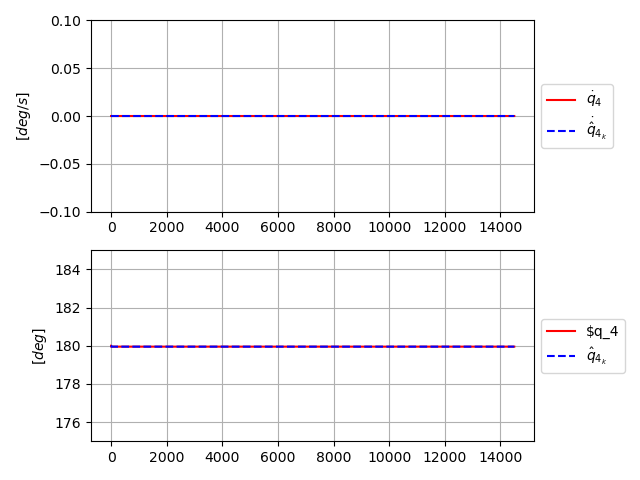

In [24]:
for i in range(len(time)):
    if np.isnan(q4[i]):
        q4[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot4[i]):
        qdot4[i] = 0
x0 = np.array([180, 0.]).T
R1, R2 = 0.1, 1
Q1, Q2 = 10, 0.01
z = np.array([q4.values, qdot4.values])
#kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=2)    
dt=0.001
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R= np.array([[R1, 0.],[0.,  R2]])
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.],[0.,  1.]])
xs4 = []
for i in range(len(q4.values)):
    kf.predict()
    kf.update(z[:,i])
    xs4.append(kf.x)
xs4 = np.array(xs4)
label1 = [r"$\dot{q}_4$",r"$\dot{\hat{q}}_{4_k}$"]
label2 = [r"$q_4",r"$\hat{q}_{4_k}$"]
plot_states(q4, qdot4, xs4, label1, label2)

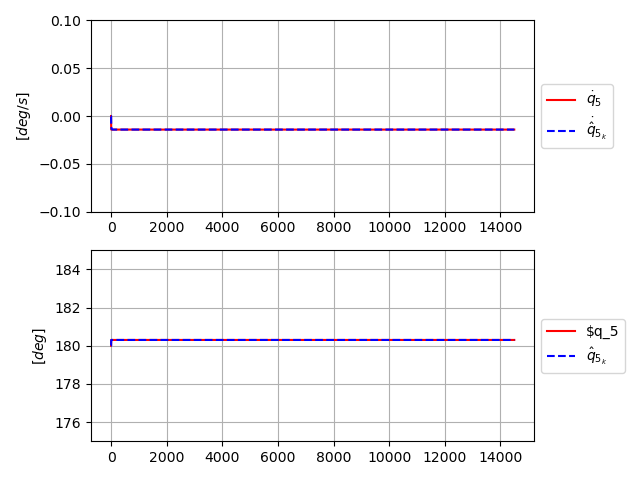

In [25]:
for i in range(len(time)):
    if np.isnan(q5[i]):
        q5[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot5[i]):
        qdot5[i] = 0
x0 = np.array([180, 0.]).T
R1, R2 = 0.1, 1
Q1, Q2 = 10, 0.01
z = np.array([q5.values, qdot5.values])
#kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=2)    
dt=0.001
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R= np.array([[R1, 0.],[0.,  R2]])
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.],[0.,  1.]])
xs5 = []
for i in range(len(q5.values)):
    kf.predict()
    kf.update(z[:,i])
    xs5.append(kf.x)
xs5 = np.array(xs5)
label1 = [r"$\dot{q}_5$",r"$\dot{\hat{q}}_{5_k}$"]
label2 = [r"$q_5",r"$\hat{q}_{5_k}$"]
plot_states(q5, qdot5, xs5, label1, label2)

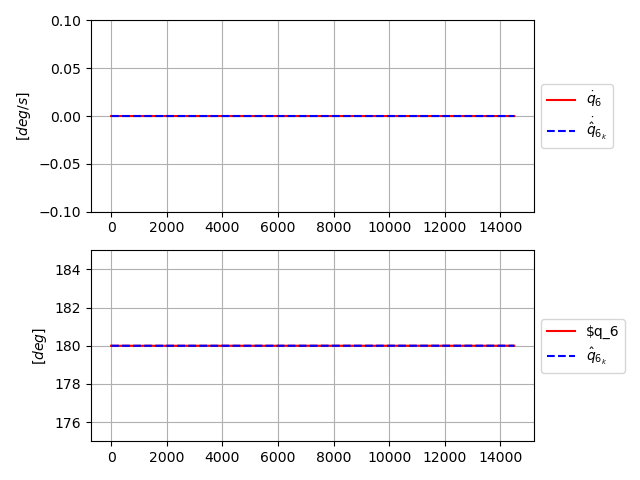

In [26]:
for i in range(len(time)):
    if np.isnan(q6[i]):
        q6[i] = 180
    
for i in range(len(time)):
    if np.isnan(qdot6[i]):
        qdot6[i] = 0
x0 = np.array([180, 0.]).T
R1, R2 = 0.1, 1
Q1, Q2 = 10, 0.01
z = np.array([q6.values, qdot6.values])
#kalman_filter(R1,R2,Q1,Q2,x0)
kf = KalmanFilter(dim_x=2, dim_z=2)    
dt=0.001
kf.x = x0
kf.P *= np.array([[1000, 0], [0, 1000]])
kf.R= np.array([[R1, 0.],[0.,  R2]])
kf.Q = np.array([[Q1, 0.],[0., Q2]])
kf.F = np.array([[1., dt],[0., 1]])
kf.H =  np.array([[1., 0.],[0.,  1.]])
xs6 = []
for i in range(len(q5.values)):
    kf.predict()
    kf.update(z[:,i])
    xs6.append(kf.x)
xs6 = np.array(xs6)
label1 = [r"$\dot{q}_6$",r"$\dot{\hat{q}}_{6_k}$"]
label2 = [r"$q_6",r"$\hat{q}_{6_k}$"]
plot_states(q6, qdot6, xs6, label1, label2)